# Smart Classroom Data Evaluation

## Setup

In [113]:
import psycopg2
import configparser
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [117]:
def read_config(filename='config.ini'):
    config = configparser.ConfigParser()
    config.read(filename)

    db_hostname = config['DATABASE']['HOSTNAME']
    db_database = config['DATABASE']['DATABASE']
    db_username = config['DATABASE']['USERNAME']
    db_password = config['DATABASE']['PASSWORD']

    return db_hostname, db_database, db_username, db_password

db_hostname, db_database, db_username, db_password =  read_config()

### Test connection

In [135]:
conn = psycopg2.connect(
    host=db_hostname,
    database=db_database,
    user=db_username,
    password=db_password)


cur = conn.cursor()
        
print('PostgreSQL database version:')
cur.execute('SELECT version()')
print(cur.fetchone())

cur.close()
conn.close()

PostgreSQL database version:
('PostgreSQL 14.2 on x86_64-pc-linux-musl, compiled by gcc (Alpine 10.3.1_git20211027) 10.3.1 20211027, 64-bit',)


### Setup connection

In [124]:
def get_connection():
    return  psycopg2.connect(
        host=db_hostname,
        database=db_database,
        user=db_username,
        password=db_password)

con = get_connection()
cur = con.cursor()

### Get The Measurements of a Classroom

In [134]:
#get all Classrooms from database and filter them
def get_measurement_from_classroom(name , con=con, startDate="2022-05-03 05:00:00", endDate="2022-05-03 15:30:00"):
    if con is None:
            con = get_connection()

    sql_stations = """
            select * from api_classroom
            inner join api_measurementstation on api_classroom.id = api_measurementstation.fk_classroom_id
            inner join api_measurement on api_measurementstation.id = api_measurement.fk_measurement_station_id
            where api_classroom.name = '{}' and time BETWEEN '{}' AND '{}';
        """.format(name, startDate, endDate)
        
    result = pd.read_sql_query(sql_stations,con)
        
    return result

## Evaluation

### Forschungsfragen

#### Wie ist der Zusammenhang zwischen Luftqualität und Frequenz bzw. Dauer des Lüftens?

--- Markdown ---

In [125]:
startDate = "2022-05-03 08:00:00"
endDate = "2022-05-03 09:30:00"
classRoom = "1" # Primarklasse_OG1

cur.execute(f"""set timezone = 'CET'; 
                SELECT  time, 
                        co2, 
                        temperature, 
                        humidity, 
                        light, 
                        motion 
                FROM api_measurement 
                WHERE time BETWEEN '{startDate}' AND '{endDate}' 
                AND fk_measurement_station_id = {classRoom}; """)
data = cur.fetchall()
data = pd.DataFrame(data)
data.columns = ["Time", "CO2", "Temperature", "Humidity", "Light", "Motion"]
data["Time"] = data["Time"].dt.tz_localize(None)

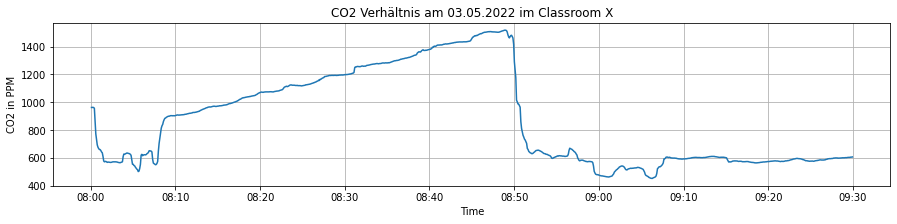

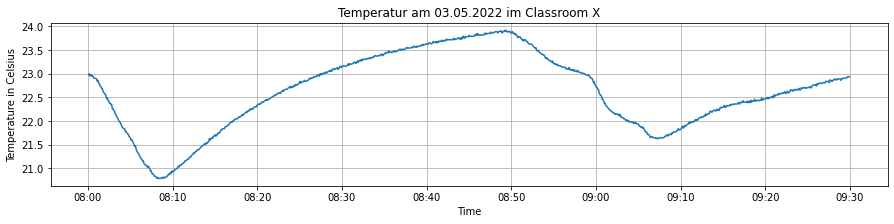

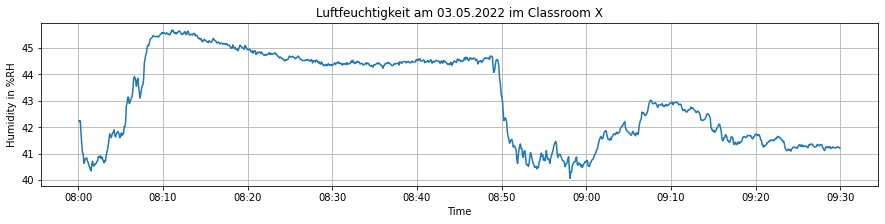

In [126]:
plt.figure(figsize = (15,3))
plt.plot(data["Time"], data["CO2"])
plt.xlabel("Time")
plt.ylabel("CO2 in PPM")
plt.title("CO2 Verhältnis am 03.05.2022 im Classroom X")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()

plt.figure(figsize = (15,3))
plt.plot(data["Time"], data["Temperature"])
plt.xlabel("Time")
plt.ylabel("Temperature in Celsius")
plt.title("Temperatur am 03.05.2022 im Classroom X")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()

plt.figure(figsize = (15,3))
plt.plot(data["Time"], data["Humidity"])
plt.xlabel("Time")
plt.ylabel("Humidity in %RH")
plt.title("Luftfeuchtigkeit am 03.05.2022 im Classroom X")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()

#### Lässt sich anhand der Luftqualität etwas über die Anzahl Personen im Raum aussagen?

Stundenplan: <br/><br/>
<img src='Stundenplan 5a.png' width=500px height=auto>

In [129]:
Measurments = get_measurement_from_classroom("Primarklasse_EG")
print(Measurments.head())

   id             name               description room_number  \
0   2  Primarklasse_EG  Primarklasse Erdgeschoss         YVO   
1   2  Primarklasse_EG  Primarklasse Erdgeschoss         YVO   
2   2  Primarklasse_EG  Primarklasse Erdgeschoss         YVO   
3   2  Primarklasse_EG  Primarklasse Erdgeschoss         YVO   
4   2  Primarklasse_EG  Primarklasse Erdgeschoss         YVO   

                        updated_on  id  active               name  \
0 2022-05-04 17:33:13.515229+00:00   2   False  Station_Primar_EG   
1 2022-05-04 17:33:13.515229+00:00   2   False  Station_Primar_EG   
2 2022-05-04 17:33:13.515229+00:00   2   False  Station_Primar_EG   
3 2022-05-04 17:33:13.515229+00:00   2   False  Station_Primar_EG   
4 2022-05-04 17:33:13.515229+00:00   2   False  Station_Primar_EG   

   fk_classroom_id       id                             time     co2  \
0                2  1022857 2022-05-03 13:29:56.950236+00:00  1245.0   
1                2  1022854 2022-05-03 13:29:51.858525+0

Stundenplan: <br/><br/>
<img src='Studenplan 4a Oben.png' width=500px height=auto>

<AxesSubplot:xlabel='time', ylabel='co2'>

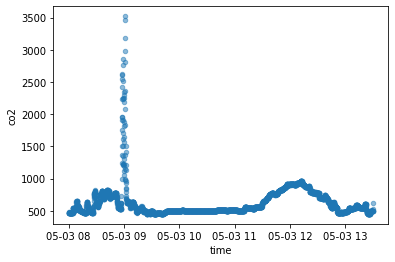

In [132]:
from datetime import datetime, date, time

Measurments = get_measurement_from_classroom("Primarklasse_OG1")
Measurments=Measurments.loc[Measurments['time'].dt.time > time(8,00)]
Measurments.plot.scatter(x="time", y="co2", alpha=0.5)

Stundenplan: <br/> <br/>
<img src='Oberstufe.png' width=500px height=auto>

In [136]:
Measurments = get_measurement_from_classroom("oberstufe")
print(Measurments.head())

   id       name              description room_number  \
0  54  oberstufe  Klassenzimmer Oberstufe           1   
1  54  oberstufe  Klassenzimmer Oberstufe           1   
2  54  oberstufe  Klassenzimmer Oberstufe           1   
3  54  oberstufe  Klassenzimmer Oberstufe           1   
4  54  oberstufe  Klassenzimmer Oberstufe           1   

                        updated_on  id  active               name  \
0 2022-05-04 18:13:31.995376+00:00   5    True  Station_Oberstufe   
1 2022-05-04 18:13:31.995376+00:00   5    True  Station_Oberstufe   
2 2022-05-04 18:13:31.995376+00:00   5    True  Station_Oberstufe   
3 2022-05-04 18:13:31.995376+00:00   5    True  Station_Oberstufe   
4 2022-05-04 18:13:31.995376+00:00   5    True  Station_Oberstufe   

   fk_classroom_id       id                             time    co2  \
0               54  1022858 2022-05-03 13:29:59.226770+00:00  474.0   
1               54  1022855 2022-05-03 13:29:54.104629+00:00  474.0   
2               54  1022853 2

#### Lässt sich aus den Messdaten der optimale Zeitpunkt zum Lüften (laufend) ermitteln?

--- Markdown ---

#### Welche weiteren Erkenntnisse lassen sich aus den erfassten Messdaten ableiten?

--- Markdown ---

#### Welche Erkenntnisse von Dritten können Sie allenfalls bestätigen/widerlegen?

--- Markdown ---

# Close Connection

In [11]:
cur.close()
conn.close()